In [30]:
import os
import glob
import numpy as np
import pandas as pd
import sys
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


In [ ]:
# define the paths to results

data_path  = 'Results/*'

# get results' file paths

file_path_list  = glob.glob(data_path)

# split file names

file_names = [file_path.split('/')[1] for file_path in file_path_list]


In [ ]:

# clear models with error

valid_models_path = [ data_path.split('*')[0] + file_name for file_name in file_names 
                                            if file_name.split('__')[0] != 'Error']

print('Number of models studied: {}'.format(len(file_names)))
print('Number of valid models: {}'.format(len(valid_models_path)))

# creating dictionary for model exploration

results_ditc = {}

n_elements = len(valid_models_path)

for results in valid_models_path:

    #Loading results

    name_it = results.split('/')[1]

    it = name_it.split('__')[-3]

    results_ditc[it] = {}

    results_ditc[it]['data'] = []

for i,results in enumerate(valid_models_path):

    #Loading results

    name_it = results.split('/')[1]

    it = name_it.split('__')[-3]

    data = np.load(results,allow_pickle=True)

    results_ditc[it]['data'].append(data[:,:-1])

    #Updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()
    


Number of models studied: 33
Number of valid models: 33
[----------------------------------------------------------------------------------------------------] 100.00% - 33 of 33

In [ ]:
concatenate = {}

for i,it in enumerate(results_ditc.keys()):

    concatenate= {
        'data':0,
        'target':0,
    }

for i,it in enumerate(results_ditc.keys()):

    if i == 0:

        data = results_ditc[it]['data'][0]

        concatenate['data'] = data[:,:-1]

        concatenate['target'] = data[:,-1]


    else:

        data = results_ditc[it]['data'][0]

        array_tuple = (concatenate['data'],data[:,:-1])

        new_array = np.vstack(array_tuple)

        concatenate['data'] = new_array

        array_tuple = (concatenate['target'],data[:,-1])

        new_array = np.hstack(array_tuple)

        concatenate['target'] = new_array

del results_ditc

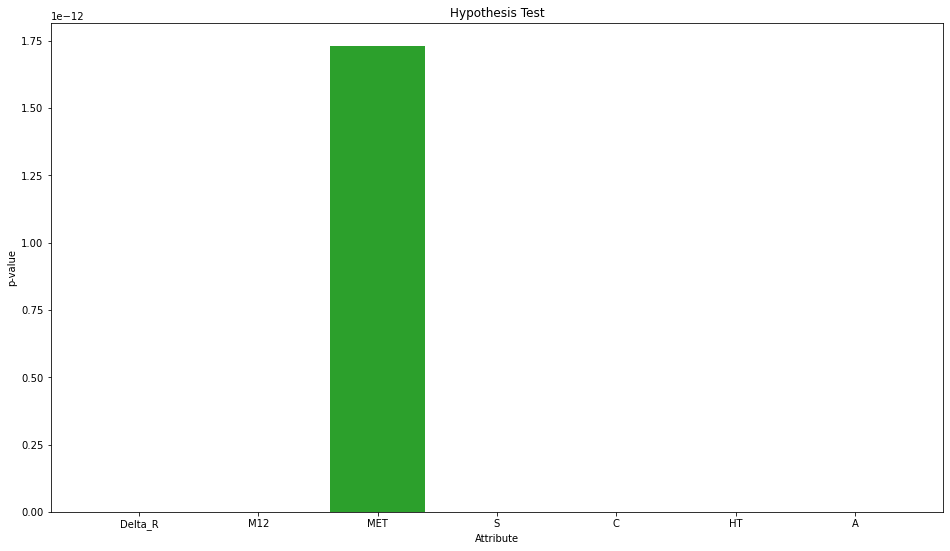

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)

for col in format_dict['erro_ks'].keys():

    p_value = format_dict['erro_ks'][col] 

    ax.bar(col , p_value)

plt.title("Hypothesis Test")
plt.ylabel("p-value")
plt.xlabel("Attribute")

fig.savefig('Figures/reconstruction-error__.png', 
            bbox_inches='tight'
        )

In [9]:
error_class = pd.DataFrame({
    'Reconstruction_error': np.array(format_dict['mse'],dtype=np.float32),
    'True_class': np.array(concatenate['target'],dtype=np.int32)
})
error_class


,Reconstruction_error,True_class
0,0.091215,0
1,0.199179,0
2,0.240624,0
3,0.108578,0
4,0.085683,0
...,...,...
989995,0.090479,1
989996,0.187180,1
989997,0.205199,1
989998,0.187924,1


In [10]:
data = np.array(format_dict['mse'],dtype=np.float32)
target = np.array(concatenate['target'],dtype=np.int32)
bg_mse = data[target==0]
sg_mse = data[target==1]


likelyhood calculed
likelyhood calculed


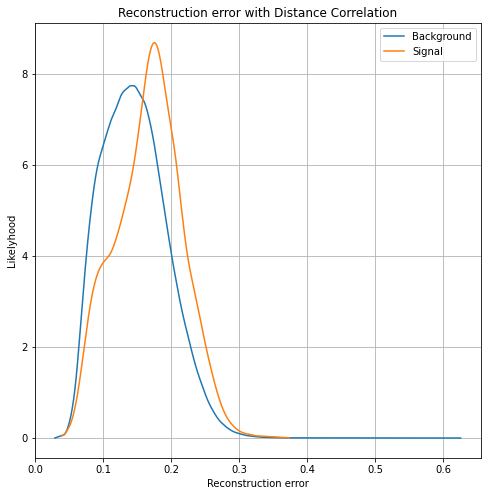

In [ ]:
threshold_fixed = 0.12
groups = error_class.groupby('True_class')

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

for name, group in groups:

    mse = group.Reconstruction_error

    kernel = stats.gaussian_kde(mse)

    mse = np.sort(mse)

    args = np.linspace(0,len(mse)-1,num=5000,dtype=int)

    mse_eval = mse[args]

    likelyhood = kernel(mse_eval)

    print('likelyhood calculed')

    if name == 0:
        labels = "Background"
    
    else:
        labels = "Signal"


    ax.plot(mse_eval, likelyhood, 
            ms=3.5, linestyle='-',
            label= labels)

ax.legend()
ax.set_title("Reconstruction error with Distance Correlation")
ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Likelyhood")
ax.grid()

plt.show()

In [ ]:

for name, group in groups:

    mse = group.Reconstruction_error

    kernel = stats.gaussian_kde(mse)

    mse = np.sort(mse)

    args = np.linspace(0,len(mse)-1,num=5000,dtype=int)

    mse_eval = mse[args]

    likelyhood = kernel(mse_eval)

    print('likelyhood calculed')

    if name == 0:
        labels = "Background"
    
    else:
        labels = "Signal"


    ax.plot(mse_eval, likelyhood, 
            ms=3.5, linestyle='-',
            label= labels)

ax.legend()
ax.set_title("Reconstruction error with Distance Correlation")
ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Likelyhood")
ax.grid()

plt.show()

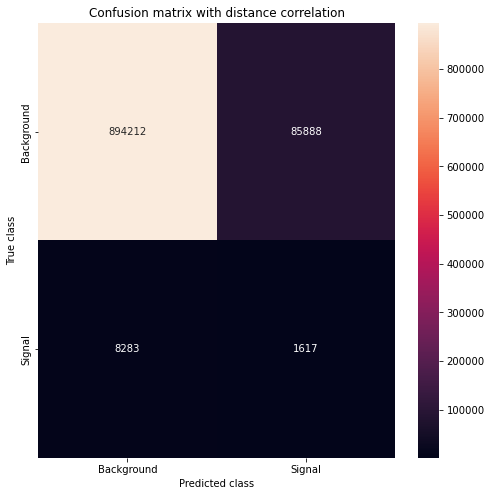

 Accuracy:  0.9048777777777778
 Recall:  0.16333333333333333
 Precision:  0.018478944060339408


In [29]:
LABELS = ['Background','Signal']

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

# with DisCo

threshold_fixed = 0.2143

pred_y = [1 if e > threshold_fixed else 0 for e in error_class.Reconstruction_error.values]
error_class['pred'] = pred_y
conf_matrix = confusion_matrix(error_class.True_class, pred_y)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
ax.set_title("Confusion matrix with distance correlation")
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

plt.show()

# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_class['True_class'], error_class['pred']))
print(" Recall: ",recall_score(error_class['True_class'], error_class['pred']))
print(" Precision: ",precision_score(error_class['True_class'], error_class['pred']))


# Análise de PCA

In [34]:
data = concatenate['data']

y = concatenate['target']

scaler = StandardScaler()

data = scaler.fit_transform(data)

pca = PCA(n_components=3).fit(data)

variacao_percentual_pca = np.round(pca.explained_variance_ratio_ * 100, decimals = 2)

print(variacao_percentual_pca.sum())


64.58


/home/thiago/yes/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


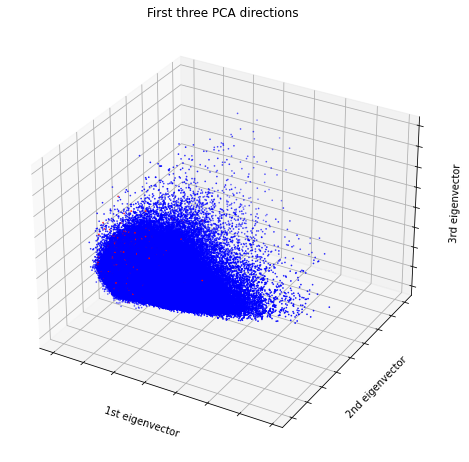

In [35]:

reduced = pca.transform(data)

colors = []

for target in y:

    if target == 0:
        colors.append('b')
    
    else:
        colors.append('r')

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions

fig = plt.figure(1, figsize=(8, 6))

ax = Axes3D(fig)

ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=colors,
           cmap=plt.cm.Set1, s=0.5)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()